# Hồi quy tuyến tính đơn giản (Simple Linear Regression)

Trong notebook này, chúng ta sẽ sử dụng dữ liệu doanh số bán nhà ở Quận King để dự đoán giá nhà sử dụng hồi quy tuyến tính đơn giản (1 đầu vào). Chúng ta sẽ:
* Sử dụng thư viện pandas để load tập dữ liệu hiện có.
* Viết một hàm tính toán trọng số của Hồi quy tuyến tính đơn giản với biểu thức dạng đóng.
* Viết một hàm dự đoán đầu ra với đặc trưng đầu vào đã cho.
* Thực hiện hồi quy để dự đoán đầu vào với đầu ra đã cho.
* So sánh 2 mô hình khác nhau dự đoán giá nhà.

Trong notebook này, các bạn sẽ được cung cấp một số code hoàn chỉnh và cũng cần tự tạo code để trả lời các quiz. Code chúng tôi cung cấp giúp bạn hoàn thiện các bài toán là tùy chọn, các bạn có thể bỏ qua helper code và viết code của riêng mình. 

## Import thư viện

In [1]:
import sklearn, pandas
import numpy as np
import matplotlib.pyplot as plt
import utils.regression as reg_utils
%matplotlib inline

## Load dữ liệu bán nhà

Tập dữ liệu từ doanh số bán nhà quận King, Seatle, WA.

In [2]:
full_data = pandas.read_csv("house_data/kc_house_data.csv", index_col=0)
full_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Đọc dữ liệu

Chúng ta sẽ chia dữ liệu thành train/test set. Để duy trì thời gian chạy nhất quán, chúng ta cần một gái trị seed (default = 0).

In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(full_data, train_size=0.8, test_size=0.2, random_state=0)

## Các hàm Pandas hữu ích

In order to make use of the closed form solution as well as taking advantage of pandas's built-in capacity, we will do some simple exercise. In particular: Để tận dụng biểu thức dạng đóng cũng như các tiện ích được tích hợp sẵn của pandas, chúng ta cùng làm một số bài tập đơn giản. Cụ thể:
* Tính tổng một cột.
* Tính trung bình cộng của các cột.
* Nhân và cập nhật một cột với một hằng số.
* Nhân một cột với giá trị của một cột khác.

In [4]:
# Hãy tính mean của House Prices in King County theo 2 cách khác nhau:
prices = full_data['price']

# gọi lại trung bình cộng, là tổng các giá chia tổng số lượng ngôi nhà:
avg_price_auto = prices.mean()
avg_price_manual = sum(prices.values) / float(len(prices))
print("average price (function): %.2f" % (avg_price_auto))
print("average price (manual):  %.2f" % (avg_price_manual))

average price (function): 540088.14
average price (manual):  540088.14


In [5]:
# nhân từng giá với 0.5 như sau:
half_prices = 0.5*prices
# Hãy tính tổng bình phương giá cả, nhân 2 SArrays có cùng độ dài với *
prices_squared = prices*prices
sum_prices_squared = prices_squared.sum() # price_squared là SArray của bình phương và chúng ta muốn thêm vào.
print("the sum of price squared is: %.2E" % (sum_prices_squared))
print("the sum of price squared is: %.4f" % (sum_prices_squared))

the sum of price squared is: 9.22E+15
the sum of price squared is: 9217325138472070.0000


Ngoài ra: Kí hiệu python x.xxe+yy nghĩa là x.xx \* 10^(yy). Ví dụ: 100 = 10^2 = 1*10^2 = 1e2

Thay thế kí hiệu số mũ (%.2E) bằng kí hiệu float (%.4f) và hiển thị sự khác biệt.

## Xây hàm hồi quy tuyến tính đơn giản chung

Với các hàm này, chúng ta có thể sử dụng biểu thức dạng đóng từ bài giảng để tính slope (độ dốc) và intercept (hệ số chặn) cho một hồi quy tuyến tính đơn giản trên các quan sát được lưu trữ dưới dạng cột DataFrame: input_feature, output.

Hoàn thành hàm sau (hoặc viết hàm của riêng mình) để tính slope và intercept của hồi quy tuyến tính đơn giản: 

**Slope:**

$$\large w_{1} = \frac{\sum_{i=1}^{N}x_{i}y_{i} - \mu(x)\sum_{i=1}^{N}y_{i}}{\sum_{i=1}^{N}x_{i}^{2} - \mu(x)\sum_{i=1}^{N}x_{i}}$$

**Intercept:**

$$\large w_{0} = \mu(y) - w_{1}\mu(x)$$

In [6]:
def simple_linear_regression(input_feature, output):
    # tính tổng của input_feature và output
    # tính tích của output và input_feature và mean của nó
    # tính giá trị bình phương của input_feature và mean của nó
    sum_x = input_feature.sum()
    sum_y = output.sum()
    mean_x = input_feature.mean()
    mean_y = output.mean()
    sum_xiyi = (input_feature*output).sum()
    sum_xi_squared = (input_feature*input_feature).sum()
            
    # sử dụng công thức tính slope
    slope = (sum_xiyi - sum_y*mean_x) / (sum_xi_squared - sum_x*mean_x)
    
    # sử dụng công thức tính intercept
    intercept = mean_y - slope*mean_x
    
    return (intercept, slope)

Chúng ta có thể kiểm tra xem hàm có hoạt động hay không bằng cách truyền cho nó một thứ gì đó cho chúng ta biết câu trả lời. 

Cụ thể, có thể tạo một đặc trưng rồi đặt đầu ra chính xác trên một dòng: $output = 1 + 1*input-feature$, sau đó chúng ta biết cả $slope$ và $intercept$ là 1

In [7]:
mock_feature = np.array(range(5))
mock_output = 1 + 1*mock_feature
(mock_intercept, mock_slope) =  simple_linear_regression(mock_feature, mock_output)
print("Intercept: %.2f" % (mock_intercept))
print("Slope: %.2f" % (mock_slope))

Intercept: 1.00
Slope: 1.00


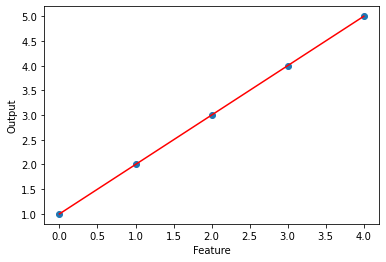

In [8]:
# Visualize the data with a scatter plot
plt.scatter(mock_feature, mock_output)
plt.plot(mock_feature, mock_intercept + mock_slope*mock_feature, 'r-')
plt.xlabel('Feature')
plt.ylabel('Output')
plt.show()

Nó đã hoạt động. Giờ hãy xây dựng mô hình hồi quy để dự đoán giá dựa trên sqft_living. Hãy nhớ chúng ta đang huấn luyện train_data!

In [9]:
sqft_features = train_data['sqft_living'].values
sqft_labels = train_data['price'].values
sqft_intercept, sqft_slope = simple_linear_regression(sqft_features, sqft_labels)

print("Intercept: %.2f" % (sqft_intercept))
print("Slope: %.2f" % (sqft_slope))

Intercept: -48257.06
Slope: 283.97


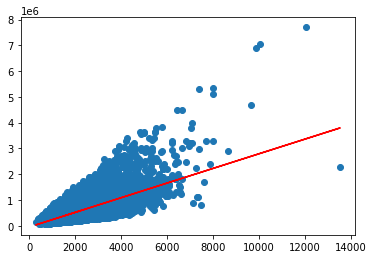

In [10]:
# Visualize the data with a scatter plot
plt.scatter(sqft_features, sqft_labels)
plt.plot(sqft_features, sqft_intercept + sqft_slope*sqft_features, 'r-')
plt.show()

# Dự đoán giá

Bây giờ chúng ta có các tham số mô hình: intercept & slope, chúng ta đã có thể đưa ra dự đoán. Với numpy, thật dễ để nhân một mảng numpy với một hằng số và thêm một giá trị không đổi. Hoàn thành hàm sau để trả về đầu ra dự đoán với input_feature, slope và intercept:

In [11]:
def get_regression_predictions(input_feature, intercept, slope):
    # tính các giá trị đã dự đoán:
    predicted_values = intercept + slope*input_feature
    return predicted_values

Hãy đưa ra dự đoán với slope và intercept. Sử dụng (hoặc thay đổi) thông tin sau để tìm ra giá ước tính cho một ngôi nhà rộng 2,000 feet vuông theo mô hình squarefeet mà chúng ta đã ước tính ở trên.

**Quiz: Với Slope và Intercept từ (4), giá dự đoán cho một ngôi nhà có diện tích 2,000 feet vuông là bao nhiêu?** 

In [12]:
my_house_sqft = 2000
estimated_price = sqft_intercept + sqft_slope*my_house_sqft
print("The estimated price for a house with %d squarefeet is $%.4f" % (my_house_sqft, estimated_price))

The estimated price for a house with 2000 squarefeet is $519680.0507


# Tổng bình phương phần dư (RSS)

Chúng ta đã có một mô hình và có thể đưa ra dự đoán, hãy đánh giá mô hình với RSS. RSS là tổng bình phương phần dư và phần dư chỉ là một từ ngữ hoa mỹ để chỉ hiệu giữa đầu ra được dự đoán và đầu ra thực.

Hoàn thành hàm sau (hoặc tự viết hàm) để tính RSS của một mô hình hồi quy tuyến tính đơn giản với input_feature, output, intercept và slope: 

In [14]:
def get_residual_sum_of_squares(input_feature, output, intercept, slope):
    # Trước tiên lấy các dự đoán
    predicted_values = intercept + slope*input_feature

    # sau đó tính các phần dư (chúng ta sẽ bình phương nên thứ tự trừ không quan trọng)
    residual = output - predicted_values

    # bình phương phần dư rồi cộng tổng lại
    RSS = (residual*residual).sum()

    return (RSS)

Hãy kiểm tra hàm `get_residual_sum_of_squares` bằng cách áp dụng nó vào mô hình kiểm thử, trong đó dữ liệu nằm chính xác trên 1 dòng. Do chúng nằm trên 1 dòng nên RSS sẽ bằng 0! 

In [15]:
print("%.2f" % get_residual_sum_of_squares(mock_feature, mock_output, mock_intercept, mock_slope)) # should be 0.0
# test utils
predicted_mock_values = mock_intercept + mock_slope*mock_feature
print("%.2f" % reg_utils.rss(mock_output, predicted_mock_values)) # should be 0.0

0.00
0.00


Bây giờ hãy sử dụng hàm của bạn để tính toán RSS trong dữ liệu huấn luyện từ mô hình squarefeet đã tính ở trên.

**Quiz: Với hàm này, slope và intercept của mô hình squarefeet thì RSS cho hồi quy tuyến tính đơn giản sử dụng squarefeet để dự đoán giá trên dữ liệu HUẤN LUYỆN là bao nhiêu?**

In [16]:
# You have made your bed, time to lie in it
train_features = train_data['sqft_living'].values
train_labels = train_data['price']
rss_prices_on_sqft = get_residual_sum_of_squares(train_features, train_labels, sqft_intercept, sqft_slope)
print('The RSS of predicting Prices based on Square Feet is : %.2E' % (rss_prices_on_sqft))

The RSS of predicting Prices based on Square Feet is : 1.21E+15


# Dự đoán squarefeet với price (giá) đã biết

Vậy nếu chúng ta muốn đoán squarefeet với price đã biết thì sao? Cho phương trình $y = a + b*x$, chúng ta có thể giải hàm tìm x. Như vậy nếu có intercept (a), slope (b) và price (y), có thể tìm squarefeet dự đoán(x). 

Hoàn thành hàm sau để tính ước lượng hồi quy ngược, tức là dự đoán input_feature với output đã biết.

In [17]:
def inverse_regression_predictions(output, intercept, slope):
    # giải output = intercept + slope*input_feature để tìm input_feature. Sử dụng phương trình này để tính dự đoán ngược:
    estimated_feature = (output - intercept) / slope
    return estimated_feature

Chúng ta đã có một hàm để tính squaredeet với giá đã biết từ mô hình hồi quy đơn giản, hãy xem cách dự kiến diện tích của một ngôi nhà với giá 800,000 USD.

**Quiz: Cho hàm này, slope và intercept từ (3), ngôi nhà giá 800,000 USD ước tính rộng bao nhiêu bao nhiêu feet vuông?**

In [18]:
# kết quả đã có, hãy thêm tham số vào hàm dưới đây 
my_house_price = 800000
estimated_squarefeet = inverse_regression_predictions(my_house_price, sqft_intercept, sqft_slope) # ở đây
print("The estimated squarefeet for a house worth $%.2f is %d" % (my_house_price, estimated_squarefeet))

The estimated squarefeet for a house worth $800000.00 is 2987


# Mô hình mới: ước tính giá từ số phòng ngủ (bedrooms)

Chúng ta đã tạo một mô hình dự đoán giá nhà bằng sử dụng squarefeet, nhưng còn nhiều đặc trưng khác trong dữ liệu bán hàng. Sử dụng hàm hồi quy tuyến tính đơn giản để ước tính các tham số hồi quy từ việc dự đoán Giá nhà dựa vào số lượng phòng ngủ. Sử dụng dữ liệu huấn luyện!

In [19]:
# Ước tính slope và intercept để dự đoán 'price' dựa theo 'bedrooms'. Sử dụng Ctrl+C và Ctrl+V 
bedroom_features = train_data['bedrooms'].values
bedroom_labels = train_data['price'].values
bedroom_intercept, bedroom_slope = simple_linear_regression(bedroom_features, bedroom_labels)

print("Bedroom - Intercept: %.2f" % (bedroom_intercept))
print("Bedroom - Slope: %.2f" % (bedroom_slope))

Bedroom - Intercept: 126751.85
Bedroom - Slope: 123535.46


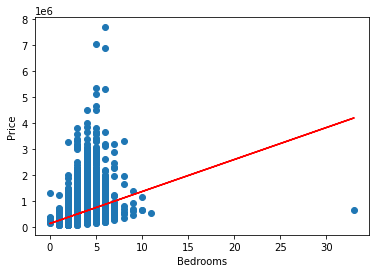

In [20]:
# Visualize the data with a scatter plot
plt.scatter(bedroom_features, bedroom_labels)
plt.plot(bedroom_features, bedroom_intercept + bedroom_slope*bedroom_features, 'r-')
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

# Kiểm tra thuật toán Hồi quy Tuyến tinh 

Chúng ta đã có 2 mô hình dự đoán giá nhà. Làm cách nào để biết mô hình nào tốt hơn? Tính RSS trên dữ liệu KIỂM TRA (dữ liệu này không liên quan đến việc học mô hình). Tính RSS từ dự đoán giá khi sử dụng bedrooms và squarefeet.

**Quiz: Mô hình nào (squarefeet hay bedrooms) có RSS thấp nhất trong dữ liệu KIỂM TRA? Lý do?**

In [21]:
# Tính RSS sử dụng bedrooms trong dữ liệu KIỂM TRA. Mức độ hỗ trợ: cao.
bdrm_test_features = test_data['bedrooms'].values
bdrm_test_labels = test_data['price'].values
rss_prices_on_bedroom = get_residual_sum_of_squares(bdrm_test_features, bdrm_test_labels, bedroom_intercept, bedroom_slope)
print("Bedroom regressions result: %.2E" % rss_prices_on_bedroom)

Bedroom regressions result: 4.73E+14


In [22]:
# Tính RSS sử dụng squarefeet trong dữ liệu KIỂM TRA. Mức độ hỗ trợ: không cao
sqft_test_features = test_data['sqft_living'].values
sqft_test_labels = test_data['price'].values
rss_prices_on_sqft = get_residual_sum_of_squares(sqft_test_features, sqft_test_labels, sqft_intercept, sqft_slope)
print("Squarefeet regressions result: %.2E" % rss_prices_on_sqft)

Squarefeet regressions result: 2.68E+14
